In [1]:
import numpy as np
import pandas as pd
from ast import literal_eval
import re
from scipy.io import mmread
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys  
sys.path.insert(0, '../scripts')

from D_plot_specificity_matrix_utils import (peptide_per_clonotype_by_gem_size,
                                             multiple_peptides_per_gem_w_filtering,
                                             calc_binding_concordance,
                                             epitope_sorter_index,
                                             peptides_per_gem)

In [3]:
def HLA_cd8_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace(",", "").replace("'","").split(" ")

def cdr3_lst_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace("'","").split(" ")

def epitope_converter(x):
    #define format of datetime
    return [y for y in x.replace("[","").replace("]","").replace("\n","").split("'") if (y != '') & (y != ' ')]

def peptide_hla_converter(x):
    return re.findall("\w+\s{1}\w{1}\d+", x.replace("[","").replace("]","").replace("\n","").replace("'",""))

def literal_converter(val):
    # replace NaN with '' and perform literal eval on the rest
    return [] if val == '' else literal_eval(val)

converters = {'peptide_HLA_lst': peptide_hla_converter,
              'umi_count_lst_mhc': literal_eval,
              'umi_count_lst_TRA': literal_converter,'umi_count_lst_TRB': literal_converter,
              'cdr3_lst_TRA': cdr3_lst_converter,
              'cdr3_lst_TRB': cdr3_lst_converter,
              'HLA_lst_mhc': cdr3_lst_converter,'HLA_cd8': HLA_cd8_converter} #

In [4]:
OS1 = '../experiments/exp13/run1/cat/eval_clonotypes/valid_ct.csv'

In [5]:
HTO = '../experiments/exp13/run1/brc/outfile.csv'
G = '../experiments/exp13/run1/brc/count/barcodes.10x.tsv.gz'
B = '../experiments/exp13/run1/brc/count/features.10x.tsv.gz'
M = '../experiments/exp13/run1/brc/count/matrix.10x.mtx.gz'

In [2]:
bla = '/home/tuba/herpov/tcr-pmhc-sc-project/experiments/exp13/run2/lib/barcode_specificity_annotations.xlsx'

In [3]:
pd.read_excel(bla, sheet_name=1, names=['barcode','sample_id','HLA_A','HLA_B','HLA_C','comment'])

,barcode,sample_id,HLA_A,HLA_B,HLA_C,comment
0,251,1,A0201,B0702,NaN,NaN
1,252,2,A0201,NaN,NaN,NaN
2,253,3,A0201,NaN,NaN,NaN
3,254,4,A0301,B0702,NaN,NaN
4,255,5,A0301,B0702,NaN,NaN
5,256,6,A0201,B0702,NaN,NaN
6,257,7,NaN,B0702,NaN,NaN
7,258,8,A0301,B0702,NaN,NaN
8,259,9,A0301,B0702,NaN,NaN
9,260,10,"A0201,A0301",B0702,NaN,NaN


# Load

In [6]:
#g = np.loadtxt(G, dtype='U36')
#b = pd.read_csv(B, sep='\t', header=None, names=['barcode','name','feature'])
#m = mmread(M)
#matrix = pd.DataFrame(m.toarray(), index=b.barcode, columns=g)

In [7]:
os1 = pd.read_csv(OS1, converters=converters)

In [8]:
hto = pd.read_csv(HTO, skiprows=1, header=None, names=['gem','seurat','umi_count_hto','feature_rna','count_hto','feature_hto','hto_max_id','hto_sec_id','hto_margin','hto_classification','hto_global_class','hash_id'])

In [9]:
hto

,gem,seurat,umi_count_hto,feature_rna,count_hto,feature_hto,hto_max_id,hto_sec_id,hto_margin,hto_classification,hto_global_class,hash_id
0,AAACCTGAGACATAAC-1,SeuratProject,955,8,955,8,10,1,1.478602,10,Singlet,10
1,AAACCTGAGATGTCGG-1,SeuratProject,3856,8,3856,8,1,4,4.078789,1_4,Doublet,Doublet
2,AAACCTGAGCCCAGCT-1,SeuratProject,4695,10,4695,10,6,3,1.009334,3_6,Doublet,Doublet
3,AAACCTGAGCTGTTCA-1,SeuratProject,310,10,310,10,3,5,3.786375,3,Singlet,3
4,AAACCTGAGTCAATAG-1,SeuratProject,2228,9,2228,9,10,2,1.635415,10,Singlet,10
...,...,...,...,...,...,...,...,...,...,...,...,...
5109,TTTGTCATCACCTCGT-1,SeuratProject,7120,10,7120,10,1,6,5.649228,1,Singlet,1
5110,TTTGTCATCACTATTC-1,SeuratProject,92,8,92,8,4,6,0.064493,Negative,Negative,Negative
5111,TTTGTCATCAGCCTAA-1,SeuratProject,1329,8,1329,8,8,10,2.781180,8,Singlet,8
5112,TTTGTCATCCCAACGG-1,SeuratProject,1717,10,1717,10,9,8,4.114530,9,Singlet,9


In [10]:
len(hto.gem.unique())

5114

In [11]:
df = pd.merge(os1, hto, how='left', on='gem')

In [12]:
os1.columns

Index(['gem', 'clonotype', 'num_clonotype', 'ct', 'genes_TRA', 'genes_TRB',
       'genes_lst_TRA', 'genes_lst_TRB', 'length_TRA', 'cdr1_TRA', 'cdr2_TRA',
       'cdr3_TRA', 'umi_count_TRA', 'umi_count_lst_TRA', 'delta_umi_TRA',
       'cdr3_lst_TRA', 'chain_count_TRA', 'single_TRA', 'length_TRB',
       'cdr1_TRB', 'cdr2_TRB', 'cdr3_TRB', 'umi_count_TRB',
       'umi_count_lst_TRB', 'delta_umi_TRB', 'cdr3_lst_TRB', 'chain_count_TRB',
       'single_TRB', 'single_chain_only', 'umi_count_tcr', 'cdr3_comb',
       'v_gene_TRA', 'j_gene_TRA', 'v_gene_TRB', 'j_gene_TRB', 'tcr_category',
       'no_filtration', 'exclude_single-chain_TCRs',
       'exclude_ambiguous_and_single-chain_TCRs', 'exclude_ambiguous_TCRs',
       'label', 'umi_count_mhc', 'umi_count_lst_mhc', 'delta_umi_mhc',
       'single_barcode_mhc', 'multiplets_mhc', 'umi_count_cd8',
       'umi_count_lst_cd8', 'delta_umi_cd8', 'single_barcode_cd8',
       'multiplets_cd8', 'detected_response', 'peptide_assayed', 'sample_id',
 

In [13]:
df.ct_pep.isna().sum()

4231

In [14]:
df['HLA_match_gem'] = df.apply(lambda row: row.peptide_HLA.split()[-1] in row.HLA_cd8 if row.peptide_HLA == row.peptide_HLA else False, axis=1)

In [15]:
df['HLA_match_ct_pep'] = df.apply(lambda row: row.ct_pep.split()[-1] in row.HLA_cd8 if row.ct_pep == row.ct_pep else np.nan, axis=1)

In [16]:
tester = df.dropna(subset=['ct_pep'])

In [17]:
df.HLA_cd8

0       [A0201, B0702]
1       [A0201, A0301]
2              [B0702]
3              [A0201]
4              [B0702]
             ...      
7106    [A0201, A0301]
7107    [A0201, A0301]
7108           [B0702]
7109           [A0201]
7110    [A0201, A0301]
Name: HLA_cd8, Length: 7111, dtype: object

In [18]:
df.loc[(df.hash_id != 'Doublet') & (df.hash_id == 'Negative'),
       ['gem','ct','peptide_HLA','peptide_HLA_lst','umi_count_lst_mhc','umi_count_mhc', 'HLA_match_gem',
        'sample_id','sample_id_lst','umi_count_lst_cd8','delta_umi_cd8','umi_count_cd8','ct_pep','ct_hla','umi_count_hto','hto_classification',
        'hash_id']].sort_values(by='ct').HLA_match_gem.value_counts()

True     245
False     42
Name: HLA_match_gem, dtype: int64

In [108]:
tester.HLA_match_ct_pep.sum() / len(tester)

0.8638888888888889

In [109]:
tester[tester.hash_id != 'Negative'].HLA_match_ct_pep.sum() / len(tester[tester.hash_id != 'Negative'])

0.8651933701657458

In [111]:
tester[(tester.hash_id != 'Doublet')].HLA_match_ct_pep.sum() / len(tester[(tester.hash_id != 'Doublet')])

0.8583032490974729

In [110]:
tester[(tester.hash_id != 'Negative') & (tester.hash_id != 'Doublet')].HLA_match_ct_pep.sum() / len(tester[(tester.hash_id != 'Negative') & (tester.hash_id != 'Doublet')])

0.8595806923451975

In [170]:
tester[(tester.umi_count_mhc >= 2) & (tester.delta_umi_mhc >= 1)&
       (~tester.umi_count_TRA.isna()) & (~tester.umi_count_TRB.isna())].HLA_match_ct_pep.sum() / len(tester[(tester.umi_count_mhc >= 2) & (tester.delta_umi_mhc >= 1)&
                                                                                                            (~tester.umi_count_TRA.isna()) & (~tester.umi_count_TRB.isna())])

0.926052332195677

In [169]:
tester[(tester.umi_count_mhc >= 2) & (tester.delta_umi_mhc >= 1.0) & (~tester.umi_count_TRA.isna()) & (~tester.umi_count_TRB.isna()) &
       (tester.hash_id != 'Negative') & (tester.hash_id != 'Doublet')].HLA_match_ct_pep.sum() / len(tester[(tester.umi_count_mhc >= 2) & (tester.delta_umi_mhc >= 1) &
                                                                                                           (~tester.umi_count_TRA.isna()) & (~tester.umi_count_TRB.isna()) &
                                                                                                           (tester.hash_id != 'Negative') & (tester.hash_id != 'Doublet')])

0.9377628259041211

In [114]:
tester[(tester.umi_count_mhc >= 2) & (tester.delta_umi_mhc >= 1) &
       (tester.hash_id != 'Negative')].HLA_match_ct_pep.sum() / len(tester[(tester.umi_count_mhc >= 2) & (tester.delta_umi_mhc >= 1) &
                                                                                                           (tester.hash_id != 'Negative')])

0.9065863108049935

In [120]:
tester[(tester.umi_count_mhc >= 2) & (tester.delta_umi_mhc >= 1) &
       (tester.hash_id != 'Doublet')].HLA_match_ct_pep.sum() / len(tester[(tester.umi_count_mhc >= 2) & (tester.delta_umi_mhc >= 1) &
                                                                                                           (tester.hash_id != 'Doublet')])

0.9095394736842105

In [87]:
df.HLA_match_gem.sum() / len(df)

0.6737449022640979

In [90]:
df[df.hash_id != 'Negative'].HLA_match_gem.sum() / len(df[df.hash_id != 'Negative'])

0.6661781946072685

In [91]:
df[df.hash_id != 'Doublet'].HLA_match_gem.sum() / len(df[df.hash_id != 'Doublet'])

0.6658832037606219

In [92]:
df[(df.hash_id != 'Doublet') & (df.hash_id != 'Negative')].HLA_match_gem.sum() / len(df[(df.hash_id != 'Doublet')  & (df.hash_id != 'Negative')])

0.6556064073226545

In [94]:
df[(df.umi_count_mhc >= 2) & (df.delta_umi_mhc >= 1)].HLA_match_gem.sum() / len(df[(df.umi_count_mhc >= 2) & (df.delta_umi_mhc >= 1)])

0.7565506452874462

In [96]:
df[(df.umi_count_mhc >= 2) & (df.delta_umi_mhc >= 1) &
   (df.hash_id != 'Negative')].HLA_match_gem.sum() / len(df[(df.umi_count_mhc >= 2) & (df.delta_umi_mhc >= 1) & (df.hash_id != 'Negative')])

0.7507768800497203

In [97]:
df[(df.umi_count_mhc >= 2) & (df.delta_umi_mhc >= 1) &
   (df.hash_id != 'Doublet')].HLA_match_gem.sum() / len(df[(df.umi_count_mhc >= 2) & (df.delta_umi_mhc >= 1) & (df.hash_id != 'Doublet')])

0.7812676853423882

In [95]:
df[(df.umi_count_mhc >= 2) & (df.delta_umi_mhc >= 1) &
   (df.hash_id != 'Negative') & (df.hash_id != 'Doublet')].HLA_match_gem.sum() / len(df[(df.umi_count_mhc >= 2) & (df.delta_umi_mhc >= 1) &
                                                                                        (df.hash_id != 'Negative') & (df.hash_id != 'Doublet')])

0.774869109947644

In [33]:
matrix.loc[:,'AAACCTGCAGCCAGAA-1']

barcode
15bp_frac_1       19
15bp_frac_2        0
15bp_frac_3        0
15bp_frac_4        0
15bp_frac_5        1
15bp_frac_6        0
15bp_frac_7        0
15bp_frac_8        0
15bp_frac_9        0
15bp_frac_10       0
15bp_frac_14       0
15bp_frac_15       0
15bp_frac_16       0
251             4645
252                5
253                0
254                0
255                0
256                4
257                4
258                7
259               16
260               15
Name: AAACCTGCAGCCAGAA-1, dtype: int64

In [19]:
df.rename(columns={'rank':'epitope_rank'},inplace=True)

In [20]:
no_flt = calc_binding_concordance(df.copy(), 'ct')
no_neg = calc_binding_concordance(df[df.hash_id != 'Negative'].copy(), 'ct')
no_dbl = calc_binding_concordance(df[df.hash_id != 'Doublet'].copy(), 'ct')
no_nth = calc_binding_concordance(df[(df.hash_id != 'Negative') & (df.hash_id != 'Doublet')].copy(), 'ct')
wt_flt = calc_binding_concordance(df[(df.umi_count_mhc >= 2) & (df.delta_umi_mhc >= 1)].copy(), 'ct')

In [21]:
wt_nth = calc_binding_concordance(df[(df.umi_count_mhc >= 2) & (df.delta_umi_mhc >= 1) &
                                     (df.hash_id != 'Negative') & (df.hash_id != 'Doublet')].copy(), 'ct')

In [22]:
wt_alt = calc_binding_concordance(df[(df.umi_count_mhc >= 2) & (df.delta_umi_mhc >= 1) &
                                     (df.hash_id != 'Doublet')].copy(), 'ct')

In [23]:
wt_wow = calc_binding_concordance(df[(df.umi_count_mhc >= 2) & (df.delta_umi_mhc >= 1) &
                                     (~df.umi_count_TRA.isna()) & (~df.umi_count_TRB.isna()) &
                                     (df.hash_id != 'Negative') & (df.hash_id != 'Doublet')].copy(), 'ct')

In [24]:
no_flt['binding_category'] = np.where(no_flt.binding_concordance > 0.5, 'normal','outlier')
no_nth['binding_category'] = np.where(no_nth.binding_concordance > 0.5, 'normal','outlier')
wt_flt['binding_category'] = np.where(wt_flt.binding_concordance > 0.5, 'normal','outlier')
wt_nth['binding_category'] = np.where(wt_nth.binding_concordance > 0.5, 'normal','outlier')

In [40]:
dfs = list()
for frame, name in zip([no_flt, no_nth, wt_flt, wt_nth], ['raw','hto','flt','hto+flt']):
    smry = frame.groupby(['binding_category','tcr_category']).size().to_frame().rename(columns={0:'freq'})
    #smry = smry.reset_index().groupby('tcr_category').freq.sum().to_frame()
    smry.loc['normal','freq'] = smry.loc['normal','freq'].values / smry.loc['normal','freq'].sum() * 100
    smry.loc['outlier','freq'] = smry.loc['outlier','freq'].values / smry.loc['outlier','freq'].sum() * 100
    smry['data'] = name
    dfs.append(smry)
    
    #g = sns.catplot(data=smry.reset_index(), col='binding_category', y='freq', x='tcr_category', kind='bar', sharey=True, margin_titles=True)
    #g.set_titles(col_template="{col_name}")#, row_template="{row_name}"
    #g.set_xlabels('')
    #plt.suptitle('Normalized difference between outliers and "normal" observations', y=1.05)
    #plt.show()
smry = pd.concat(dfs)

In [26]:
smry#.reset_index().groupby('tcr_category').freq.sum()

,freq,data
tcr_category,,
missing chain,2770,raw
multiple chains,421,raw
unique chains,3920,raw
missing chain,2159,hto
multiple chains,234,hto
unique chains,2851,hto
missing chain,1685,flt
multiple chains,314,flt
unique chains,3115,flt


In [28]:
for name in ['hto','flt','hto+flt']:
    for category in ['missing chain','multiple chains','unique chains']:
        a = smry[smry.data=='raw'].loc[category,'freq']
        b = smry[smry.data== name].loc[category,'freq']

        print(name, category, (a-b)/a*100)

hto missing chain 22.057761732851986
hto multiple chains 44.418052256532064
hto unique chains 27.27040816326531
flt missing chain 39.16967509025271
flt multiple chains 25.415676959619955
flt unique chains 20.535714285714285
hto+flt missing chain 61.227436823104696
hto+flt multiple chains 69.83372921615202
hto+flt unique chains 47.80612244897959


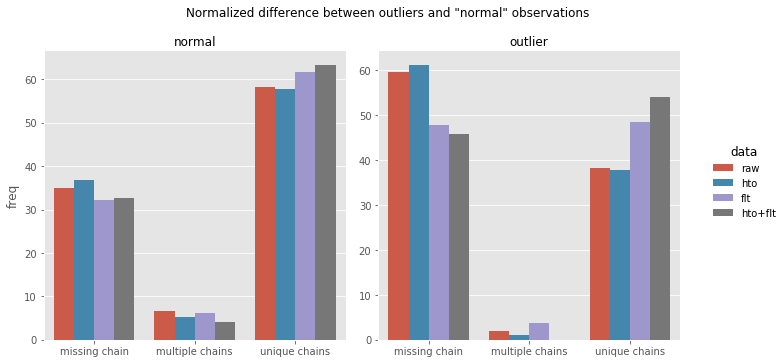

In [41]:
g = sns.catplot(data=smry.reset_index(), col='binding_category', y='freq', x='tcr_category', hue='data', kind='bar', sharey=False, margin_titles=True)
g.set_titles(col_template="{col_name}")#, row_template="{row_name}"
g.set_xlabels('')
plt.suptitle('Normalized difference between outliers and "normal" observations', y=1.05)
plt.show()

In [34]:
no_flt[['single_barcode_mhc',
 'multiplets_mhc']]

,single_barcode_mhc,multiplets_mhc
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True
...,...,...
7106,False,True
7107,False,True
7108,False,True
7109,False,True


In [36]:
dfs = list()
for frame, name in zip([no_flt, no_nth, wt_flt, wt_nth], ['raw','hto','flt','hto+flt']):
    lol = frame.groupby(['binding_category','single_barcode_mhc']).size().to_frame().rename(columns={0:'freq'})
    lol['data'] = name
    dfs.append(lol)
    
lol = pd.concat(dfs)

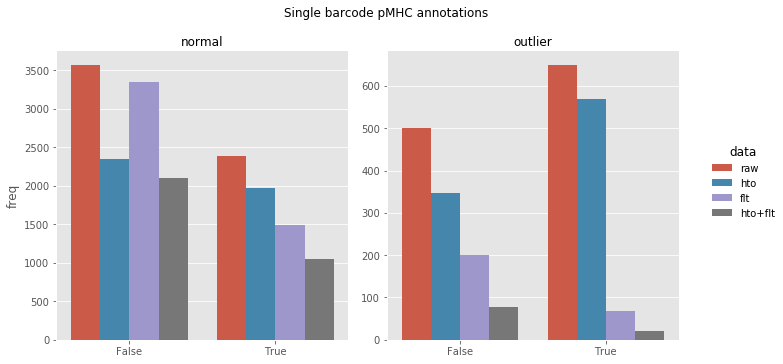

In [39]:
g = sns.catplot(data=lol.reset_index(), col='binding_category', y='freq', x='single_barcode_mhc', hue='data', kind='bar', sharey=False, margin_titles=True)
g.set_titles(col_template="{col_name}")#, row_template="{row_name}"
g.set_xlabels('')
plt.suptitle('Single barcode pMHC annotations', y=1.05)
plt.show()

{4100, 6148, 4104, 9, 2056, 4109, 14, 6163, 6165, 33, 6180, 6185, 43, 46, 47, 6190, 4149, 2102, 2104, 6205, 4158, 6212, 6214, 6215, 6225, 4184, 2136, 6236, 96, 6243, 4198, 6247, 6246, 6250, 6260, 2174, 6280, 6282, 2188, 6288, 2197, 6294, 6296, 4253, 2205, 6303, 6304, 4255, 2210, 165, 6310, 2215, 6314, 2220, 4275, 180, 2232, 6330, 195, 4300, 204, 4304, 6355, 6359, 6363, 221, 2281, 6377, 6385, 6386, 6387, 6388, 4341, 2293, 6391, 4350, 6398, 6400, 4353, 6402, 6405, 2311, 6408, 4361, 6413, 282, 287, 4385, 6436, 4389, 4388, 6444, 2356, 6453, 310, 2359, 6462, 2369, 4418, 327, 6474, 2379, 2383, 2389, 6487, 4442, 347, 6495, 2402, 4452, 4453, 6507, 366, 6510, 369, 2428, 2429, 2439, 6537, 394, 4492, 6542, 398, 2446, 6546, 405, 6554, 6557, 6560, 6562, 422, 423, 6569, 4522, 4529, 6578, 435, 437, 4538, 4539, 6593, 6596, 454, 4551, 2504, 4552, 2518, 6617, 4570, 6620, 6639, 4593, 6645, 2556, 6655, 511, 513, 522, 6675, 532, 6677, 4631, 6679, 6682, 2589, 4637, 544, 2592, 6707, 2612, 563, 570, 6724, 467

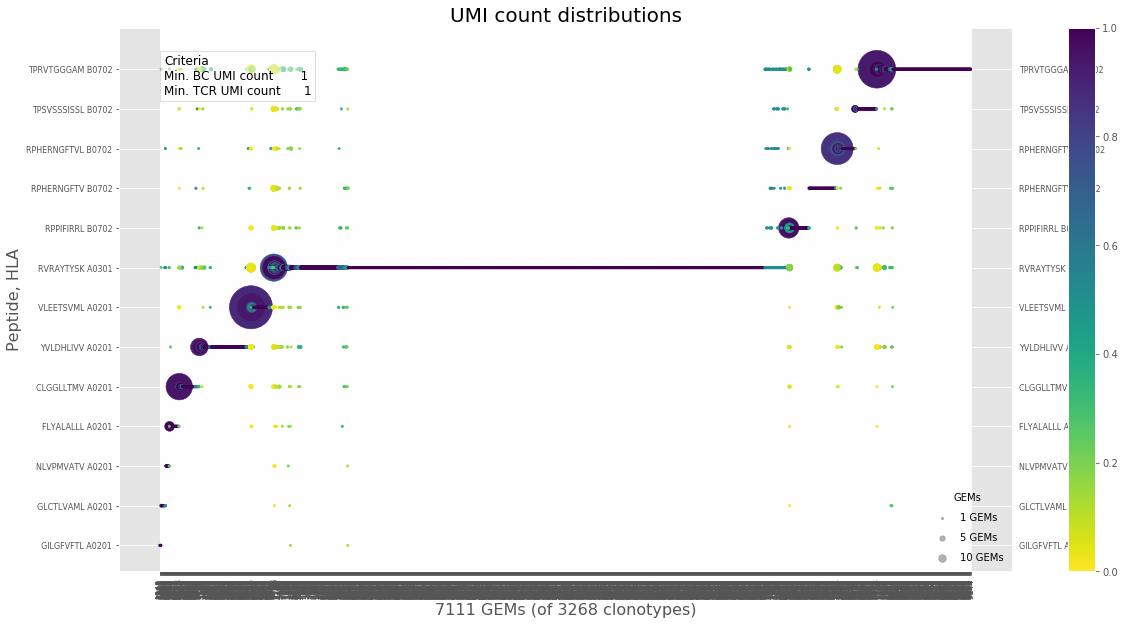

OBS! Figures are not saved!


In [80]:
peptide_per_clonotype_by_gem_size(no_flt, y='peptide_HLA', color_by_hashing=False, show=True)

{6148, 4100, 4104, 9, 2056, 4109, 14, 6163, 6165, 33, 6185, 43, 46, 47, 6190, 4149, 2102, 2104, 6205, 4158, 6212, 6214, 6215, 6225, 4184, 2136, 6236, 96, 6243, 4198, 6247, 6246, 6250, 6260, 2174, 6280, 6282, 2188, 6288, 2197, 6294, 6296, 4253, 6303, 4255, 2210, 165, 6310, 2215, 6314, 2220, 4275, 180, 2232, 6330, 195, 4300, 204, 4304, 6355, 6359, 6363, 221, 6377, 6385, 6386, 6388, 4341, 2293, 6391, 4350, 6398, 6400, 4353, 6402, 6405, 2311, 6408, 4361, 6413, 282, 287, 4385, 6436, 4389, 4388, 6444, 2356, 6453, 310, 2359, 6462, 2369, 4418, 327, 6474, 2379, 2383, 2389, 6487, 4442, 347, 6495, 2402, 4452, 4453, 6507, 366, 6510, 369, 2428, 2429, 2439, 6537, 394, 4492, 6542, 2446, 6546, 405, 6554, 6557, 6560, 6562, 422, 423, 6569, 4522, 4529, 6578, 435, 437, 4538, 4539, 6593, 6596, 454, 4551, 2504, 4552, 2518, 6617, 4570, 6639, 4593, 6645, 2556, 6655, 511, 513, 6675, 532, 6677, 6679, 6682, 2589, 4637, 544, 2592, 6707, 2612, 563, 570, 6724, 4679, 6728, 6738, 6745, 6747, 6751, 6752, 608, 610, 265

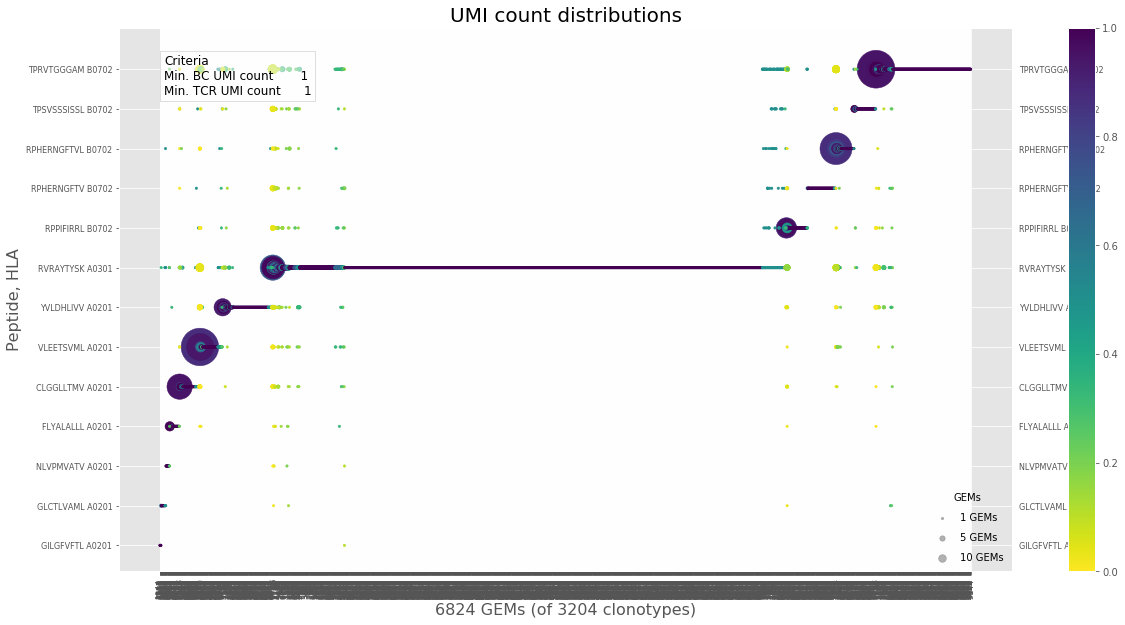

OBS! Figures are not saved!


In [77]:
peptide_per_clonotype_by_gem_size(lol, y='peptide_HLA', color_by_hashing=False, show=True)

{4100, 6148, 2056, 9, 4109, 14, 6163, 6165, 33, 6180, 6185, 43, 46, 6190, 50, 4149, 2104, 6205, 4158, 6212, 6214, 6225, 4184, 6236, 96, 6243, 4198, 6247, 6246, 6250, 2174, 6280, 2188, 6288, 6294, 6296, 2205, 6303, 6304, 4255, 2210, 165, 2215, 6314, 2220, 4275, 180, 2232, 6330, 195, 4300, 204, 4304, 6355, 6363, 4327, 2281, 6377, 6385, 6386, 6387, 6388, 4341, 6391, 4350, 6398, 6400, 4353, 6402, 6405, 2311, 6408, 4361, 6413, 282, 287, 4385, 6436, 4389, 4388, 6444, 6453, 310, 2359, 6462, 2369, 4418, 327, 6474, 2379, 2389, 6487, 4442, 347, 6495, 4452, 4453, 6507, 366, 6510, 369, 2428, 2429, 2439, 6537, 394, 4492, 398, 6542, 405, 6554, 6557, 6560, 6562, 422, 423, 6569, 4522, 4529, 435, 437, 6593, 6596, 454, 4551, 2504, 4552, 2518, 6617, 4570, 6639, 4593, 6645, 2556, 511, 6655, 513, 522, 532, 6677, 4631, 6679, 6682, 4637, 544, 6707, 2612, 570, 6724, 4679, 6728, 6738, 6745, 6747, 6751, 6752, 608, 2664, 636, 4734, 4735, 6782, 6792, 6793, 6795, 6797, 2717, 6814, 670, 6817, 677, 6822, 2725, 6824,

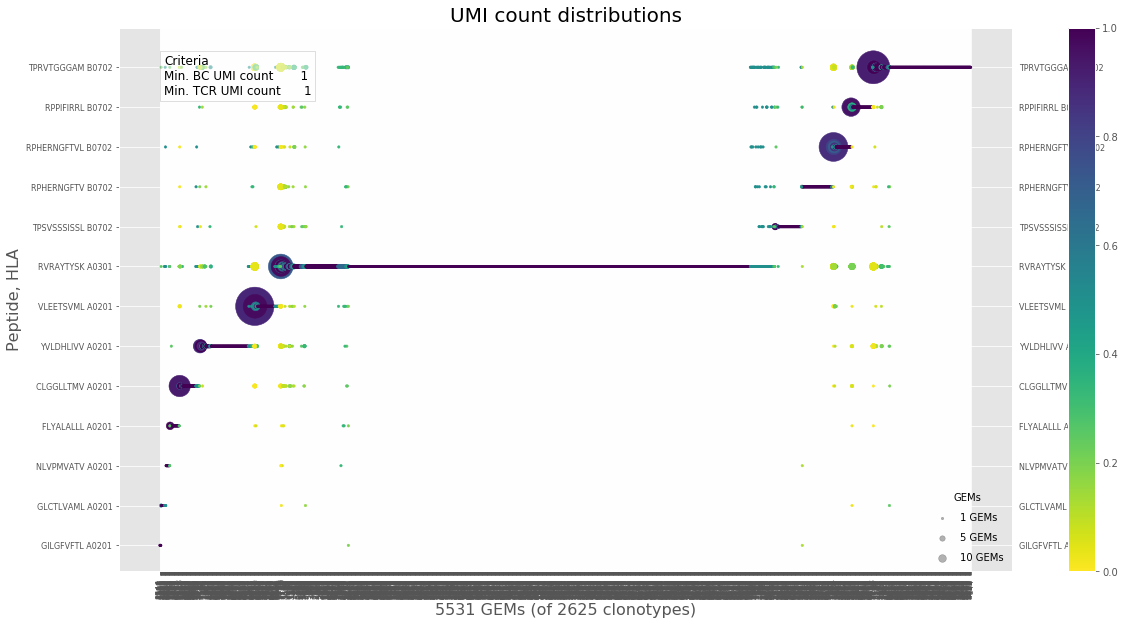

OBS! Figures are not saved!


In [81]:
peptide_per_clonotype_by_gem_size(no_dbl, y='peptide_HLA', color_by_hashing=False, show=True)

{4100, 6148, 2056, 9, 4109, 14, 6163, 6165, 33, 6185, 43, 46, 6190, 50, 4149, 2104, 6205, 4158, 6212, 6214, 6225, 4184, 6236, 96, 6243, 4198, 6247, 6246, 6250, 2174, 6280, 2188, 6288, 6294, 6296, 6303, 4255, 2210, 165, 2215, 6314, 2220, 4275, 180, 2232, 6330, 195, 4300, 204, 4304, 6355, 6363, 4327, 6377, 6385, 6386, 6388, 4341, 6391, 4350, 6398, 6400, 4353, 6402, 6405, 2311, 6408, 4361, 6413, 282, 287, 4385, 6436, 4389, 4388, 6444, 6453, 310, 2359, 6462, 2369, 4418, 327, 6474, 2379, 2389, 6487, 4442, 347, 6495, 4452, 4453, 6507, 366, 6510, 369, 2428, 2429, 2439, 6537, 394, 4492, 6542, 405, 6554, 6557, 6560, 6562, 422, 423, 6569, 4522, 4529, 435, 437, 6593, 6596, 454, 4551, 2504, 4552, 2518, 6617, 4570, 6639, 4593, 6645, 2556, 511, 6655, 513, 522, 532, 6677, 6679, 6682, 4637, 544, 6707, 2612, 570, 6724, 4679, 6728, 6738, 6745, 6747, 6751, 6752, 608, 2664, 636, 4734, 4735, 6782, 6792, 6795, 6797, 2717, 6814, 6817, 677, 6822, 2725, 6824, 6825, 6826, 6827, 682, 4781, 4782, 6834, 2739, 693,

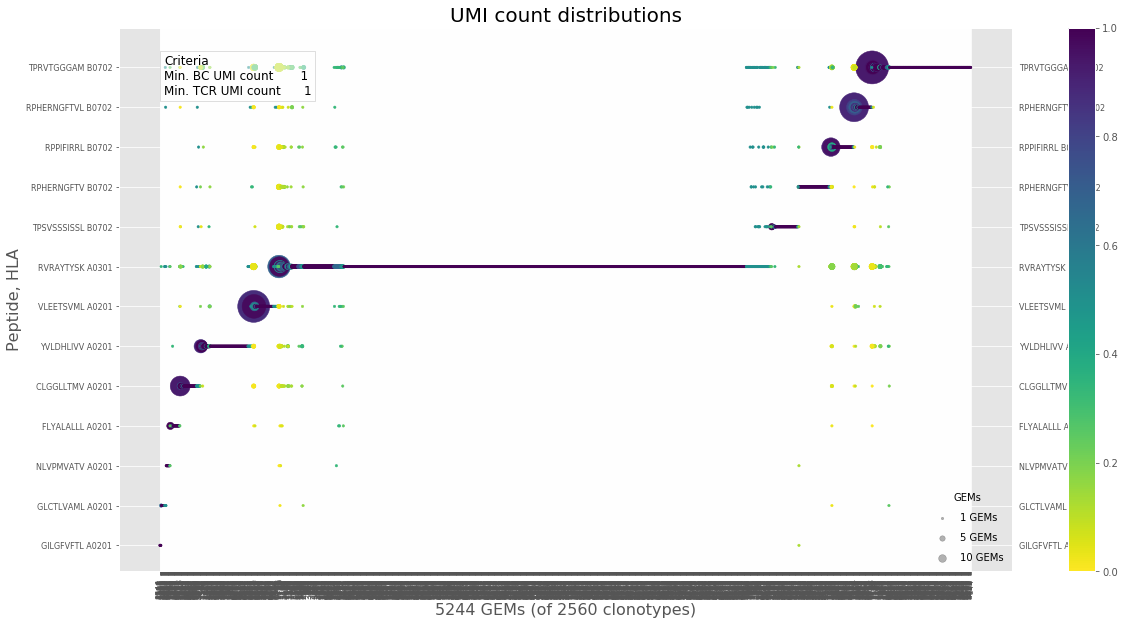

OBS! Figures are not saved!


In [82]:
peptide_per_clonotype_by_gem_size(no_nth, y='peptide_HLA', color_by_hashing=False, show=True)

{3077, 5126, 4104, 1528, 3082, 4109, 1037, 1549, 5138, 4631, 3099, 2589, 2592, 1581, 3630, 5680, 563, 2102, 1600, 1613, 5202, 5715, 1107, 1624, 2136, 5725, 5726, 6752, 1650, 3698, 5236, 6260, 5235, 5756, 2687, 4735, 641, 3203, 6280, 6793, 6282, 6797, 1677, 1679, 5264, 654, 3215, 2707, 1683, 2197, 4253, 670, 4255, 6304, 2205, 165, 6827, 6829, 1717, 5827, 3271, 1735, 4813, 6359, 2776, 4828, 733, 2783, 6881, 6893, 6387, 3827, 2293, 2806, 6909, 4353, 6919, 2311, 5906, 4883, 3349, 6936, 1817, 4890, 3360, 6436, 4388, 808, 4907, 6957, 2862, 5933, 2356, 842, 2894, 6998, 7001, 5471, 5472, 1375, 2402, 3428, 2916, 2923, 366, 3950, 7023, 1392, 4984, 3448, 2428, 5501, 2429, 5502, 7042, 3970, 7044, 7049, 394, 3465, 398, 3471, 7056, 6542, 2446, 405, 1944, 6044, 6048, 5028, 6053, 422, 3492, 2988, 7085, 5550, 5037, 1453, 6578, 5561, 4538, 4539, 6076, 7110, 5575, 3531, 3543, 1500, 5089, 6115, 997, 3558, 6119, 3570, 5620, 2040, 6137, 5626}


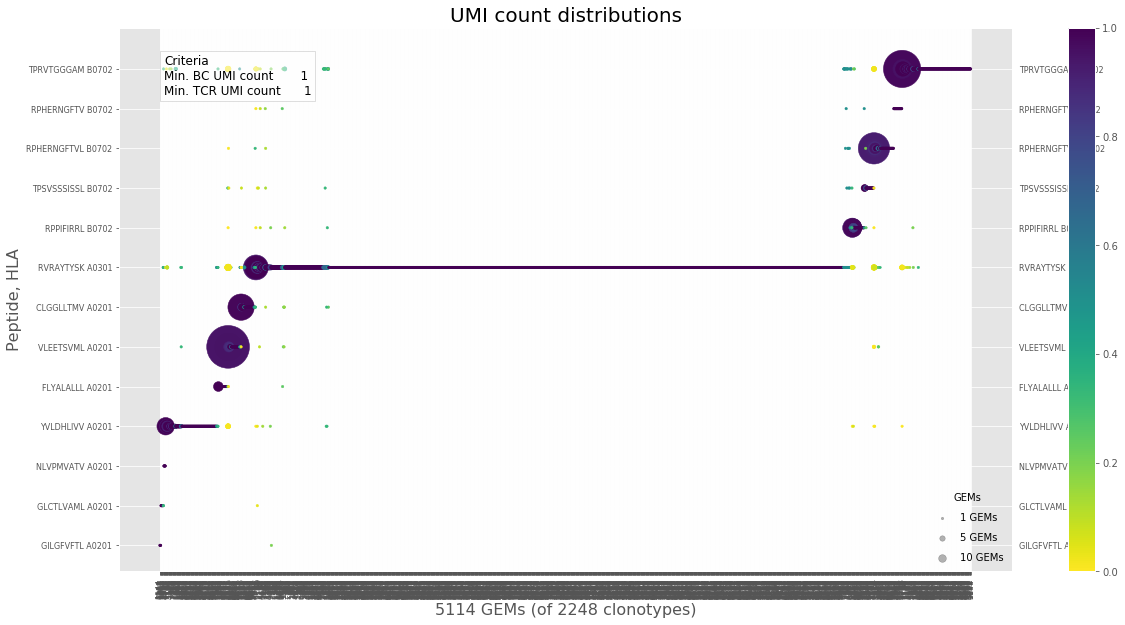

OBS! Figures are not saved!


In [84]:
peptide_per_clonotype_by_gem_size(wt_flt, y='peptide_HLA', color_by_hashing=False, show=True)

{4353, 5126, 2311, 6280, 7049, 3082, 394, 6797, 4109, 1037, 6542, 1677, 1683, 405, 2839, 1944, 1817, 4890, 6044, 4255, 6048, 6436, 6053, 165, 422, 808, 4388, 3492, 6827, 5933, 1581, 1717, 1853, 1600, 5827, 3531, 2894, 6998, 3543, 2776, 4828, 6752, 6115, 3428, 6893, 366, 3950, 3827, 5620, 5235, 2806, 4984, 6137, 5626, 2428, 2429, 5502, 4735}


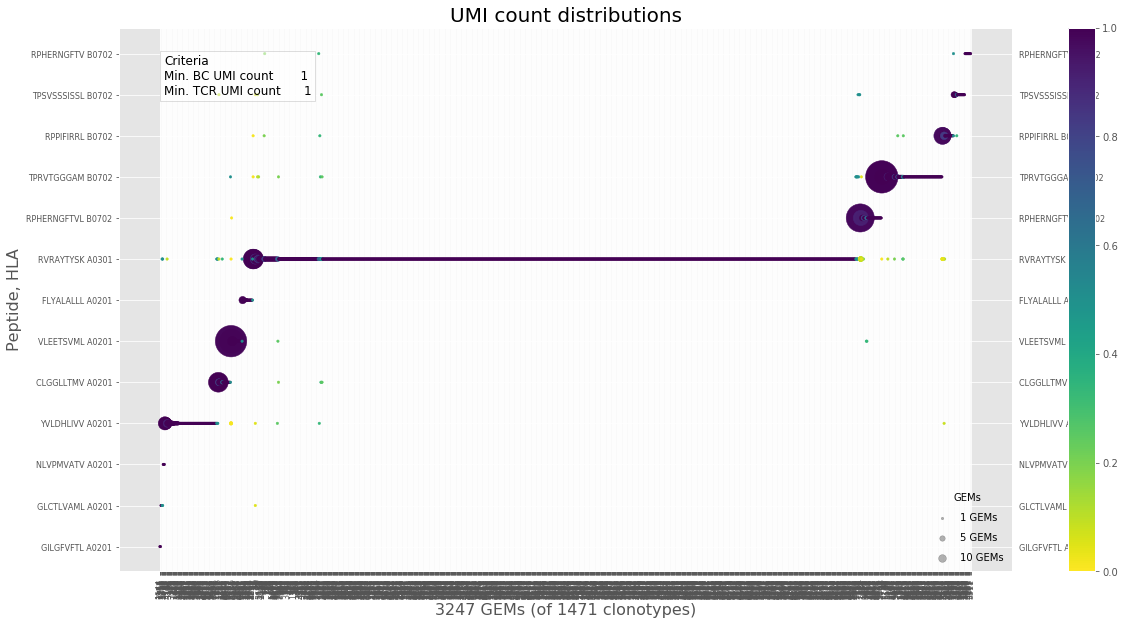

OBS! Figures are not saved!


In [86]:
peptide_per_clonotype_by_gem_size(wt_nth, y='peptide_HLA', color_by_hashing=False, show=True)

{3077, 5126, 3082, 4109, 1037, 5138, 4631, 1581, 1600, 5715, 5726, 6752, 5235, 5236, 5756, 4735, 3203, 6280, 6793, 6797, 1677, 5264, 1683, 2205, 670, 4255, 165, 6827, 6829, 1717, 5827, 2776, 4828, 2783, 6893, 6387, 3827, 2806, 4353, 2311, 5906, 4883, 2839, 1817, 4890, 6436, 4388, 808, 6957, 5933, 1853, 2894, 6998, 1375, 5472, 3428, 366, 3950, 7023, 4984, 2428, 2429, 5502, 7044, 7049, 3465, 394, 398, 6542, 405, 1944, 1947, 6044, 6048, 3492, 6053, 422, 7085, 5561, 6076, 7110, 5575, 3531, 3543, 5089, 6115, 5620, 1528, 6137, 5626}


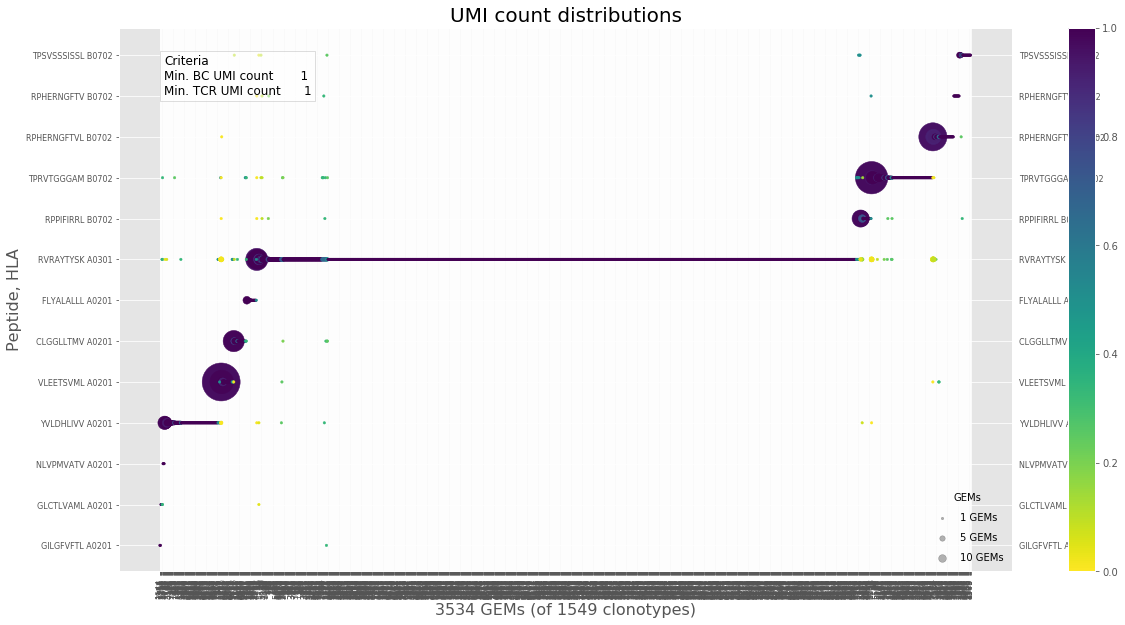

OBS! Figures are not saved!


In [99]:
peptide_per_clonotype_by_gem_size(wt_alt, y='peptide_HLA', color_by_hashing=False, show=True)

{4353, 2311, 3082, 394, 4109, 1037, 1677, 1683, 405, 2839, 1944, 1817, 4255, 4388, 165, 3492, 808, 1853, 1600, 3531, 2894, 3543, 4828, 3428, 366, 3950, 2806, 2428, 4735}


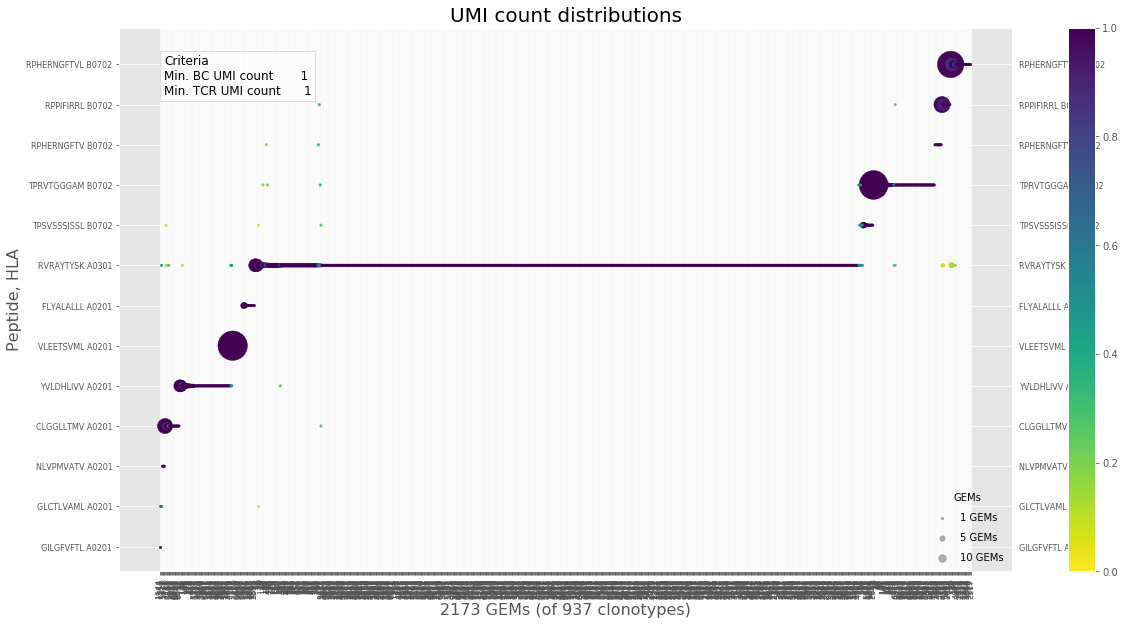

OBS! Figures are not saved!


In [172]:
peptide_per_clonotype_by_gem_size(wt_wow, y='peptide_HLA', color_by_hashing=False, show=True)

In [138]:
outliers = {4353, 5126, 2311, 6280, 7049, 3082, 394, 6797, 4109, 1037, 6542, 1677, 1683, 405, 2839, 1944, 1817, 4890, 6044, 4255, 6048, 6436, 6053, 165, 422, 808, 
            4388, 3492, 6827, 5933, 1581, 1717, 1853, 1600, 5827, 3531, 2894, 6998, 3543, 2776, 4828, 6752, 6115, 3428, 6893, 366, 3950, 3827, 5620, 5235, 2806, 
            4984, 6137, 5626, 2428, 2429, 5502, 4735}

In [164]:
wt_nth.loc[wt_nth.binding_concordance < 0.5, ['ct','umi_count_TRA','umi_count_TRB','peptide_HLA_lst','peptide_HLA','HLA_cd8','umi_count_lst_mhc','binding_concordance','sample_id_lst','hash_id','ct_pep','ct_hla']].sort_values(by='ct')#.loc[df.ct == 165, ['hash_id']]

,ct,umi_count_TRA,umi_count_TRB,peptide_HLA_lst,peptide_HLA,HLA_cd8,umi_count_lst_mhc,binding_concordance,sample_id_lst,hash_id,ct_pep,ct_hla
6752,1.0,NaN,1.0,"[CLGGLLTMV A0201, RVRAYTYSK A0301, VLEETSVML A...",YVLDHLIVV A0201,"[A0201, A0301]","[1.0, 1.0, 9.0, 10.0]",0.011905,"[5, 1, 6, 7, 8, 10]",10,VLEETSVML A0201,NaN
5626,1.0,NaN,15.0,"[TPRVTGGGAM B0702, VLEETSVML A0201, YVLDHLIVV ...",YVLDHLIVV A0201,"[A0201, A0301]","[3.0, 23.0, 76.0]",0.011905,"[5, 3, 9, 2, 7, 1, 6, 8, 10]",10,VLEETSVML A0201,NaN
6137,1.0,NaN,4.0,"[VLEETSVML A0201, RPHERNGFTVL B0702, RVRAYTYSK...",RVRAYTYSK A0301,[A0201],"[1.0, 1.0, 3.0]",0.005952,"[4, 3, 7, 9, 8, 6, 1, 10, 2]",2,VLEETSVML A0201,NaN
6542,2.0,NaN,9.0,"[TPSVSSSISSL B0702, RPPIFIRRL B0702]",RPPIFIRRL B0702,"[A0201, A0301]","[2.0, 3.0]",0.014925,"[3, 7, 5, 8, 6, 2, 9, 1, 4, 10]",10,RVRAYTYSK A0301,NaN
5235,2.0,NaN,8.0,"[CLGGLLTMV A0201, RVRAYTYSK A0301, TPRVTGGGAM ...",TPRVTGGGAM B0702,"[A0201, A0301]","[1.0, 3.0, 6.0]",0.014925,"[1, 2, 4, 7, 3, 8, 9, 6, 10]",10,RVRAYTYSK A0301,NaN
5620,3.0,NaN,1.0,[RVRAYTYSK A0301],RVRAYTYSK A0301,"[A0301, B0702]",[3.0],0.005682,"[5, 7, 9, 2, 3, 8, 1, 6, 10, 4]",4,TPRVTGGGAM B0702,B0702
4828,4.0,4.0,5.0,"[RPPIFIRRL B0702, TPRVTGGGAM B0702, RPHERNGFTV...",RVRAYTYSK A0301,[B0702],"[1.0, 1.0, 4.0, 20.0]",0.022222,"[4, 1, 6, 9, 2, 7, 10, 8]",8,RPHERNGFTVL B0702,B0702
6827,4.0,NaN,5.0,"[RPHERNGFTVL B0702, RVRAYTYSK A0301]",RVRAYTYSK A0301,[B0702],"[1.0, 3.0]",0.022222,"[2, 7, 6, 9, 1, 10, 8]",8,RPHERNGFTVL B0702,B0702
4109,4.0,5.0,8.0,"[RPHERNGFTVL B0702, RPPIFIRRL B0702, RVRAYTYSK...",RVRAYTYSK A0301,[B0702],"[1.0, 1.0, 2.0]",0.022222,"[2, 3, 7, 9, 4, 6, 1, 10, 8]",8,RPHERNGFTVL B0702,B0702
2776,5.0,1.0,NaN,"[CLGGLLTMV A0201, RVRAYTYSK A0301, RPHERNGFTVL...",RPHERNGFTVL B0702,[B0702],"[1.0, 1.0, 8.0]",0.010753,"[5, 3, 8, 4, 2, 1, 6, 10, 7]",7,VLEETSVML A0201,A0201


# Decisiontree

In [173]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

## Feature selection

In [224]:
tester.columns.to_list()

['gem',
 'clonotype',
 'num_clonotype',
 'ct',
 'genes_TRA',
 'genes_TRB',
 'genes_lst_TRA',
 'genes_lst_TRB',
 'length_TRA',
 'cdr1_TRA',
 'cdr2_TRA',
 'cdr3_TRA',
 'umi_count_TRA',
 'umi_count_lst_TRA',
 'delta_umi_TRA',
 'cdr3_lst_TRA',
 'chain_count_TRA',
 'single_TRA',
 'length_TRB',
 'cdr1_TRB',
 'cdr2_TRB',
 'cdr3_TRB',
 'umi_count_TRB',
 'umi_count_lst_TRB',
 'delta_umi_TRB',
 'cdr3_lst_TRB',
 'chain_count_TRB',
 'single_TRB',
 'single_chain_only',
 'umi_count_tcr',
 'cdr3_comb',
 'v_gene_TRA',
 'j_gene_TRA',
 'v_gene_TRB',
 'j_gene_TRB',
 'tcr_category',
 'no_filtration',
 'exclude_single-chain_TCRs',
 'exclude_ambiguous_and_single-chain_TCRs',
 'exclude_ambiguous_TCRs',
 'label',
 'umi_count_mhc',
 'umi_count_lst_mhc',
 'delta_umi_mhc',
 'single_barcode_mhc',
 'multiplets_mhc',
 'umi_count_cd8',
 'umi_count_lst_cd8',
 'delta_umi_cd8',
 'single_barcode_cd8',
 'multiplets_cd8',
 'detected_response',
 'peptide_assayed',
 'sample_id',
 'sample_id_lst',
 'HLA_pool_cd8',
 'HLA_lst_

In [231]:
tester.hash_id = tester.hash_id.fillna(0).astype(str)

/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [178]:
tester['label'] = tester.apply(lambda row: row.peptide_HLA == row.ct_pep, axis=1).astype(int)

/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [249]:
#split dataset in features and target variable
feature_cols = ['umi_count_mhc', 'delta_umi_mhc', 'umi_count_cd8', 'delta_umi_cd8','umi_count_TRA','delta_umi_TRA','umi_count_TRB','delta_umi_TRB','hash_id']
X = tester[feature_cols].fillna(0) # Features
y = tester.label # Target variable

In [250]:
one_hot_X = pd.get_dummies(X, drop_first=True)

In [243]:
one_hot_X

,umi_count_mhc,delta_umi_mhc,umi_count_cd8,delta_umi_cd8,umi_count_TRA,delta_umi_TRA,umi_count_TRB,delta_umi_TRB,hash_id_1,hash_id_10,hash_id_2,hash_id_3,hash_id_4,hash_id_5,hash_id_6,hash_id_7,hash_id_8,hash_id_9,hash_id_Doublet,hash_id_Negative
2,7.0,5.600000,1724.0,77.483146,3.0,12.0,4.0,16.0,0,0,0,0,0,0,0,0,1,0,0,0
3,19.0,15.200000,4645.0,285.846154,1.0,4.0,5.0,20.0,1,0,0,0,0,0,0,0,0,0,0,0
4,33.0,26.400000,2224.0,91.711340,1.0,4.0,10.0,40.0,0,0,0,0,0,0,0,1,0,0,0,0
10,52.0,208.000000,1560.0,102.295082,2.0,1.6,3.0,12.0,0,0,0,0,1,0,0,0,0,0,0,0
14,1.0,4.000000,593.0,32.493151,3.0,12.0,9.0,36.0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7095,40.0,17.777778,1764.0,1.452749,0.0,0.0,9.0,36.0,0,0,0,0,0,0,0,0,0,0,1,0
7099,8.0,3.555556,3808.0,118.077519,0.0,0.0,4.0,16.0,0,0,1,0,0,0,0,0,0,0,0,0
7101,1.0,4.000000,17.0,2.344828,0.0,0.0,1.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0
7106,3.0,2.400000,723.0,34.023529,0.0,0.0,4.0,16.0,0,0,0,0,0,0,0,0,0,0,1,0


In [251]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(one_hot_X, y, test_size=0.3, random_state=1) # 70% training and 30% test

## Build and predict

In [245]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [246]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8796296296296297


In [200]:
r = sklearn.tree.export_text(clf, feature_names=feature_cols)
print(r)

AttributeError: module 'sklearn.tree' has no attribute 'export_text'

In [254]:
X_test['label'] = y_test
X_test['pred'] = y_pred

/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [260]:
X_test[(X_test.label == 1) & (X_test.pred == 1)].sort_values(by=['umi_count_mhc','delta_umi_mhc']).head(60)#.umi_count_mhc.value_counts().head(60)

,umi_count_mhc,delta_umi_mhc,umi_count_cd8,delta_umi_cd8,umi_count_TRA,delta_umi_TRA,umi_count_TRB,delta_umi_TRB,hash_id_1,hash_id_10,...,hash_id_4,hash_id_5,hash_id_6,hash_id_7,hash_id_8,hash_id_9,hash_id_Doublet,hash_id_Negative,label,pred
4594,1.0,0.800000,260.0,12.839506,2.0,8.0,10.0,40.0,0,0,...,0,0,0,0,0,0,0,0,1,1
5069,1.0,4.000000,143.0,22.880000,0.0,0.0,4.0,16.0,0,0,...,0,0,0,0,0,0,0,0,1,1
6693,1.0,4.000000,537.0,21.267327,0.0,0.0,11.0,44.0,0,0,...,0,0,0,0,0,0,0,0,1,1
2829,1.0,4.000000,2838.0,276.878049,3.0,12.0,19.0,76.0,0,0,...,0,0,0,0,0,0,0,0,1,1
7018,1.0,4.000000,3684.0,1.948949,0.0,0.0,24.0,96.0,0,0,...,0,0,0,0,0,0,0,0,1,1
6517,1.0,4.000000,2584.0,229.688889,0.0,0.0,2.0,8.0,0,0,...,0,0,0,0,0,0,0,0,1,1
6642,1.0,4.000000,68.0,12.952381,0.0,0.0,3.0,12.0,0,0,...,0,0,0,0,0,0,0,0,1,1
6201,1.0,4.000000,79.0,4.861538,0.0,0.0,4.0,16.0,0,0,...,0,0,0,0,0,0,0,0,1,1
3497,1.0,4.000000,129.0,10.530612,1.0,4.0,1.0,4.0,0,0,...,0,0,0,0,0,0,0,0,1,1
6806,1.0,4.000000,169.0,11.081967,0.0,0.0,5.0,20.0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [192]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
#import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('diabetes.png')
#Image(graph.create_png())

In [191]:
from sklearn import tree 
tree.plot_tree(clf)
plt.show()

AttributeError: module 'sklearn.tree' has no attribute 'plot_tree'

In [189]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

ModuleNotFoundError: No module named 'graphviz'

In [190]:
import sklearn
print(sklearn.__version__)

0.20.3


In [252]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9108796296296297
